# NorCoast analysis 

Import av python modules used for the analysis

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.externals.six import StringIO
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pydotplus as pydot
import math
import mglearn
import seaborn as sns
import xgboost as xgb

Load csv file that contains MRI scoring data and clinical data like age, cognitive scoring and so on.

In [89]:
network_df = pd.read_csv('network_base.csv')

Create list with features. One with and the other without age!

In [90]:
select_columns_with_age = ['ID','MTA-pathology-yes','koedam_path','Evans_path','fazekas_path','Lacunes','MicroB','age_at_stroke']
select_columns = ['ID','MTA-pathology-yes','koedam_path','Evans_path','fazekas_path','Lacunes','MicroB']
value_columns= ['Lacunes', 'Fazekas', 'age_at_stroke', 'moca_sum', 'nihss_score_in', 'MTA-mean', 'Evans']
pathology_columns = select_columns[1:]

Handle some Nan and calculate sum of scores that are not contained in the clinical spreadsheet!

In [91]:
network_df[select_columns] = network_df[select_columns].fillna(value=0).astype(int)

In [92]:
network_df['sum_pathology'] = network_df[pathology_columns].sum(axis=1)

In [93]:
network_df['network_group_id'] = network_df[pathology_columns].astype(str).apply(''.join, axis=1)

In [94]:
network_df['Evans'] = round(network_df['Evans'], 2)

In [95]:
network_df['AD8_sum'] = network_df.loc[:, network_df.columns.str.contains('AD8')].replace([2,3],0).sum(axis=1) 

Age is divided into bins to give clearer visualization!

In [96]:
network_df['age_decade'] = pd.cut(network_df['age_at_stroke'], bins=[0,30,40,50,60,70,80,90,100], right=False)

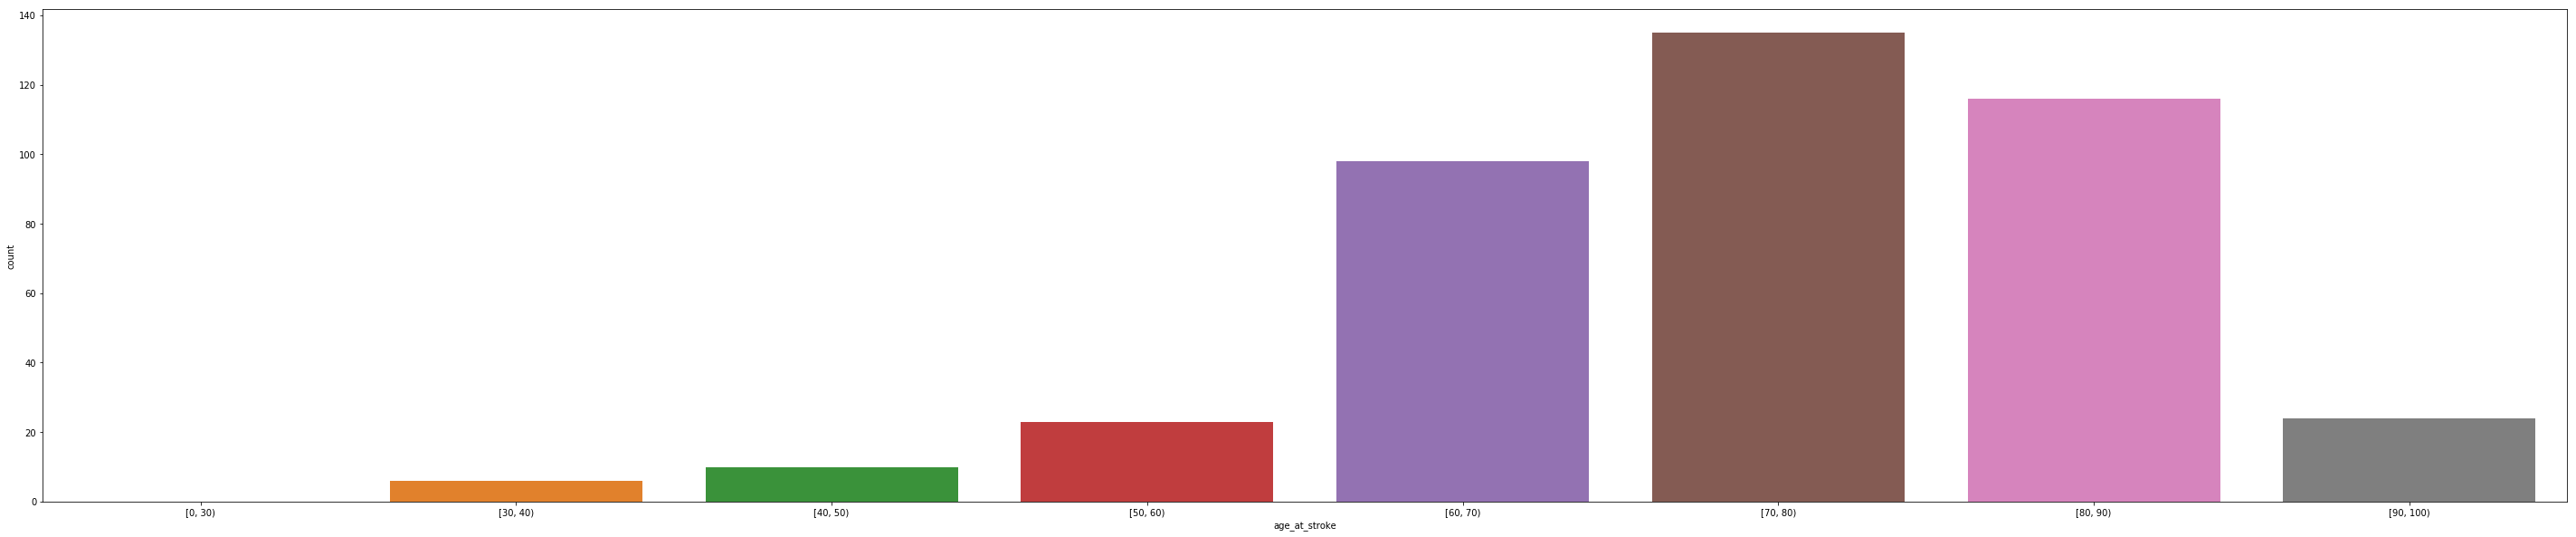

In [97]:
#network_df[select_columns]
sns.countplot(pd.cut(network_df['age_at_stroke'], bins=[0,30,40,50,60,70,80,90,100], right=False))

### Create GDS_path as binary variable from prestroke_GDS_T0 6 (prestroke_GDS_T0 of 1 is negative = 0; the rest is pathological = 1)

In [98]:
network_df['GDS_path'] = network_df['prestroke_GDS_T0']

In [99]:
network_df['GDS_path'].replace(1,0, inplace=True)

In [100]:
network_df['GDS_path'].replace([2,3,4,5,6], 1, inplace=True)

In [101]:
decision_df = network_df.loc[~network_df['prestroke_GDS_T0'].isnull()]

Create feature matrix and label matrix without age!

In [102]:
X = decision_df.loc[:, select_columns[1:]]
y = decision_df.loc[:, 'GDS_path']

Split feature and label matrix in train and test dataset!

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

### Instantiate  Decision Tree classifier

In [104]:
dt = DecisionTreeClassifier(max_depth=3)

Fit model. 

In [105]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Predict labels on test feature matrix and score perdictions

In [106]:
y_pred = dt.predict(X_test)

In [107]:
accuracy_score(y_test, y_pred)

0.7407407407407407

### Brier score

In [108]:
brier_score_loss(y_test, y_pred)

0.25925925925925924

In [109]:
dot_data = StringIO

In [110]:
import graphviz

In [111]:
export_graphviz(dt, out_file='tree.dot', class_names=['GDS_normal','GDS_pathological'], feature_names=list(X), impurity=False, filled=True)

### Plot Decision Tree

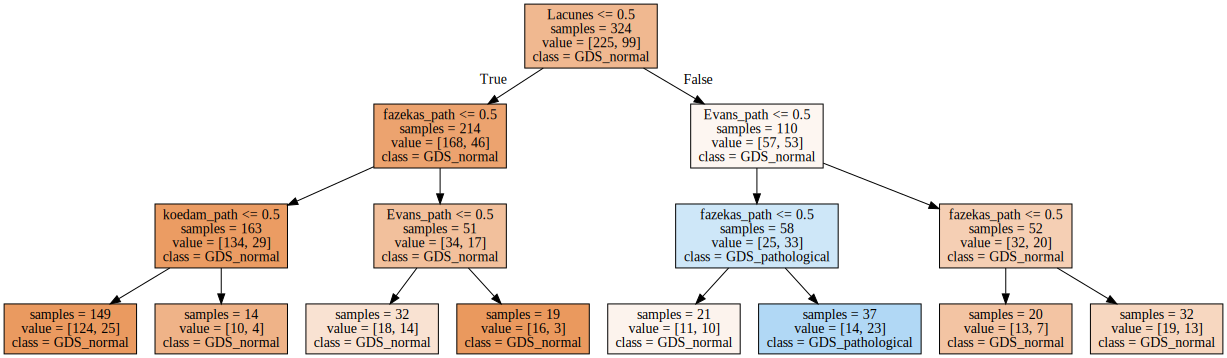

In [112]:
with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Plot feature importance

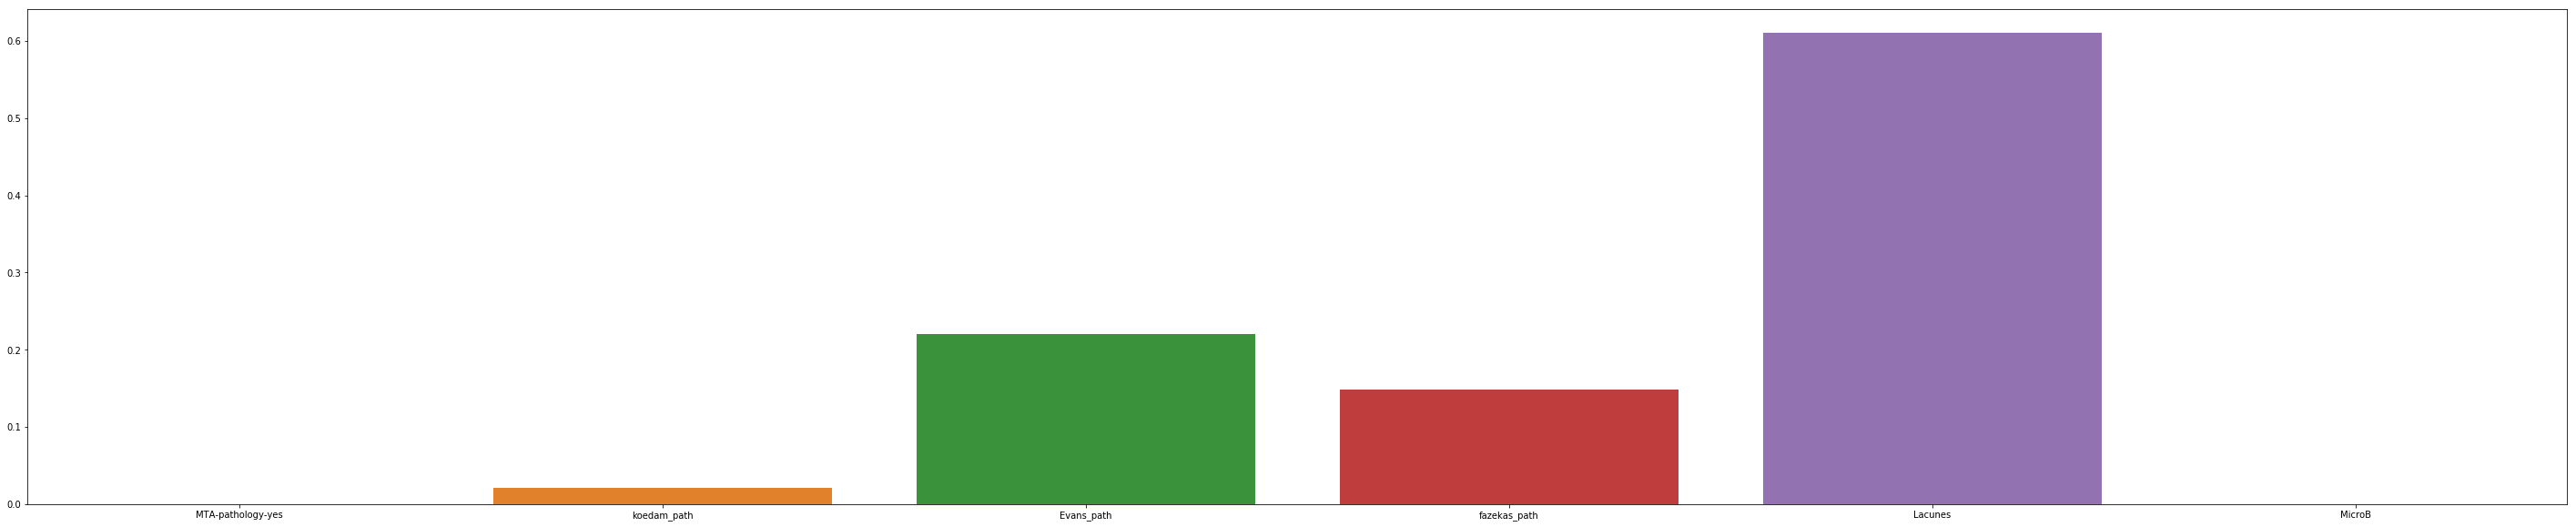

In [113]:
sns.barplot(x=select_columns[1:], y=dt.feature_importances_)


In [114]:
print(dt.feature_importances_)

[0.         0.02099643 0.21987806 0.14871577 0.61040975 0.        ]


## Same Decision tree, but this time with age in the feature matrix

In [115]:
X_age = decision_df.loc[:, select_columns_with_age[1:]]

In [116]:
X_age_train, X_age_test, y_train, y_test = train_test_split(X_age, y, test_size=0.2, stratify=y, random_state=1)

In [117]:
dt = DecisionTreeClassifier(max_depth=3)

In [118]:
dt.fit(X_age_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [119]:
y_pred = dt.predict(X_age_test)

In [120]:
brier_score_loss(y_test, y_pred)

0.4444444444444444

In [121]:
export_graphviz(dt, out_file='tree.dot', class_names=['GDS_normal','GDS_pathological'], feature_names=list(X_age), impurity=False, filled=True)

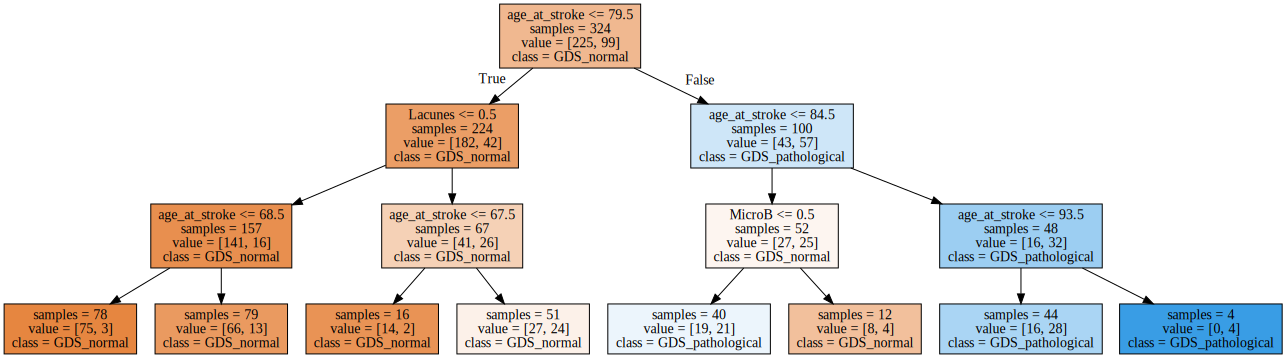

In [122]:
with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

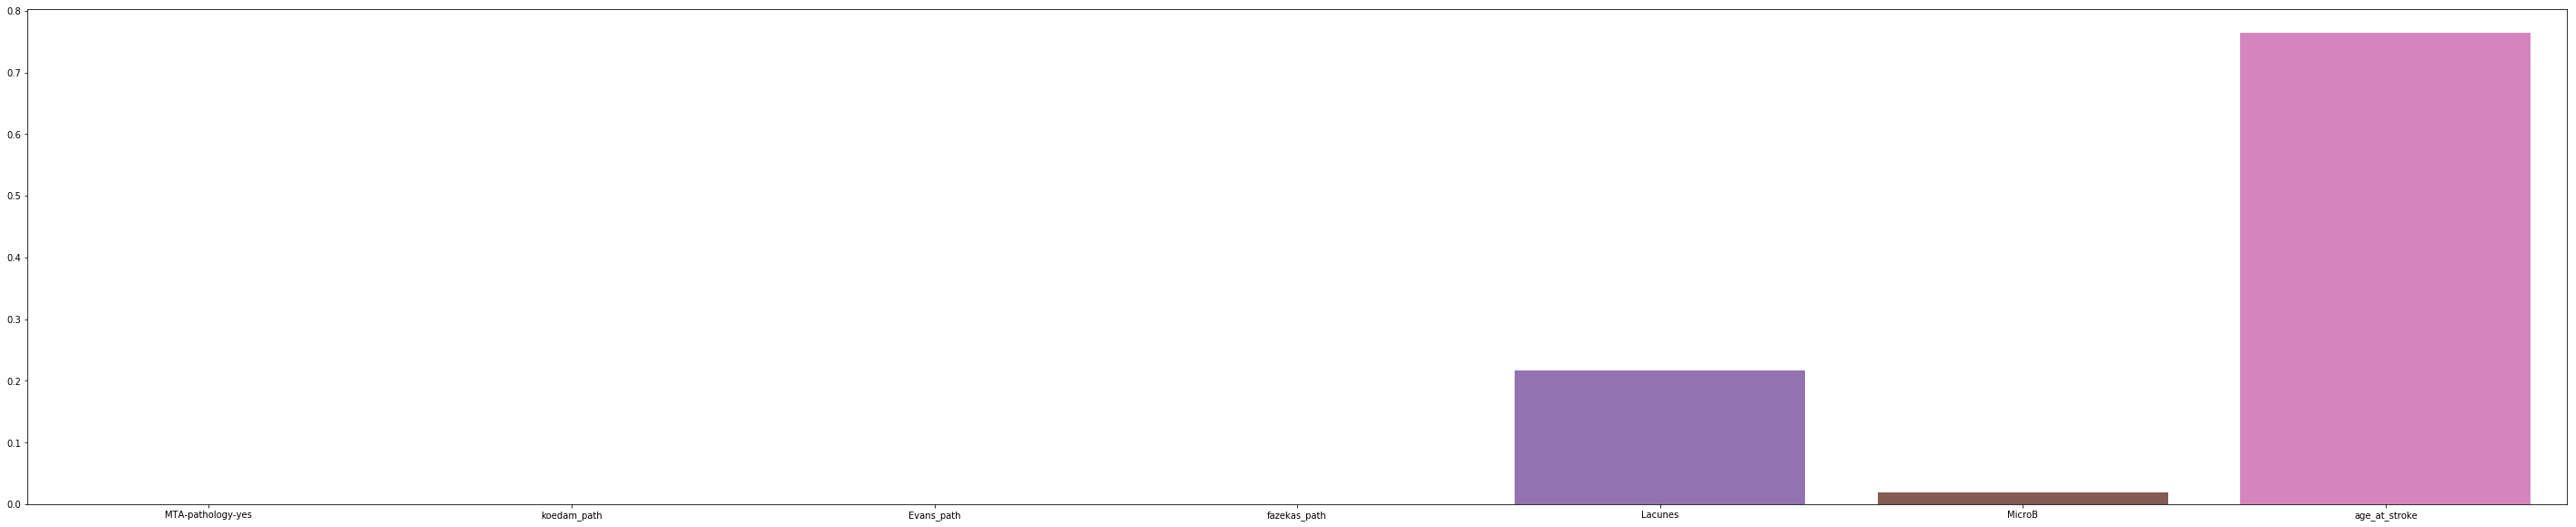

In [123]:
sns.barplot(x=select_columns_with_age[1:], y=dt.feature_importances_)
plt.show()

## Random Forest Classifier 

In [124]:
random_forrest = RandomForestClassifier(max_depth=4)

In [125]:
random_forrest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [126]:
y_predict = random_forrest.predict(X_test)

In [127]:
accuracy_score(y_predict, y_test)

0.7160493827160493

In [128]:
brier_score_loss(y_predict, y_test)

0.2839506172839506

## XGBoost

In [129]:
# fig, axes = plt.subplots(2,3)

In [145]:
data_matrix = xgb.DMatrix(data=X, label=y)

In [146]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.8, learning_rate=0.1, max_depth=4, alpha=10, n_estimators=10)

In [147]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [148]:
pred = xgb_classifier.predict(X_test)

/Users/tillschellhorn/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [149]:
rmse = np.sqrt(mean_squared_error(y_test, pred))

In [150]:
rmse

0.49690399499995325

In [151]:
accuracy_score(y_test, pred)

0.7530864197530864

In [152]:
brier_score_loss(y_test, pred)

0.24691358024691357

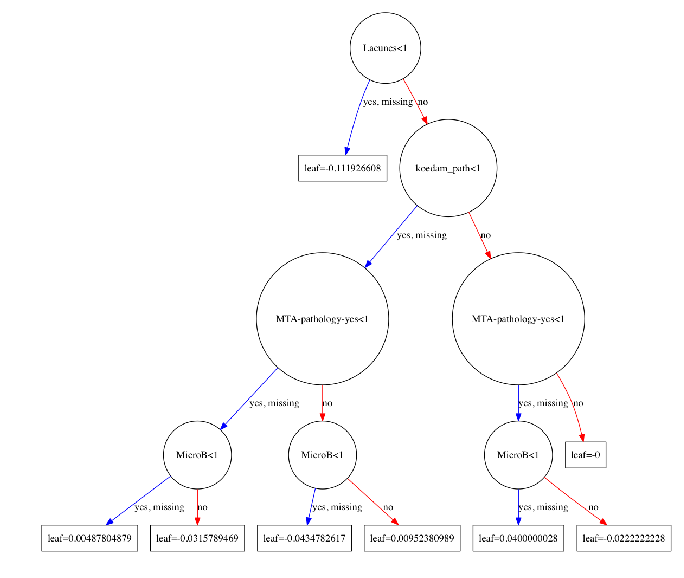

In [153]:
xgb.plot_tree(xgb_classifier, num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

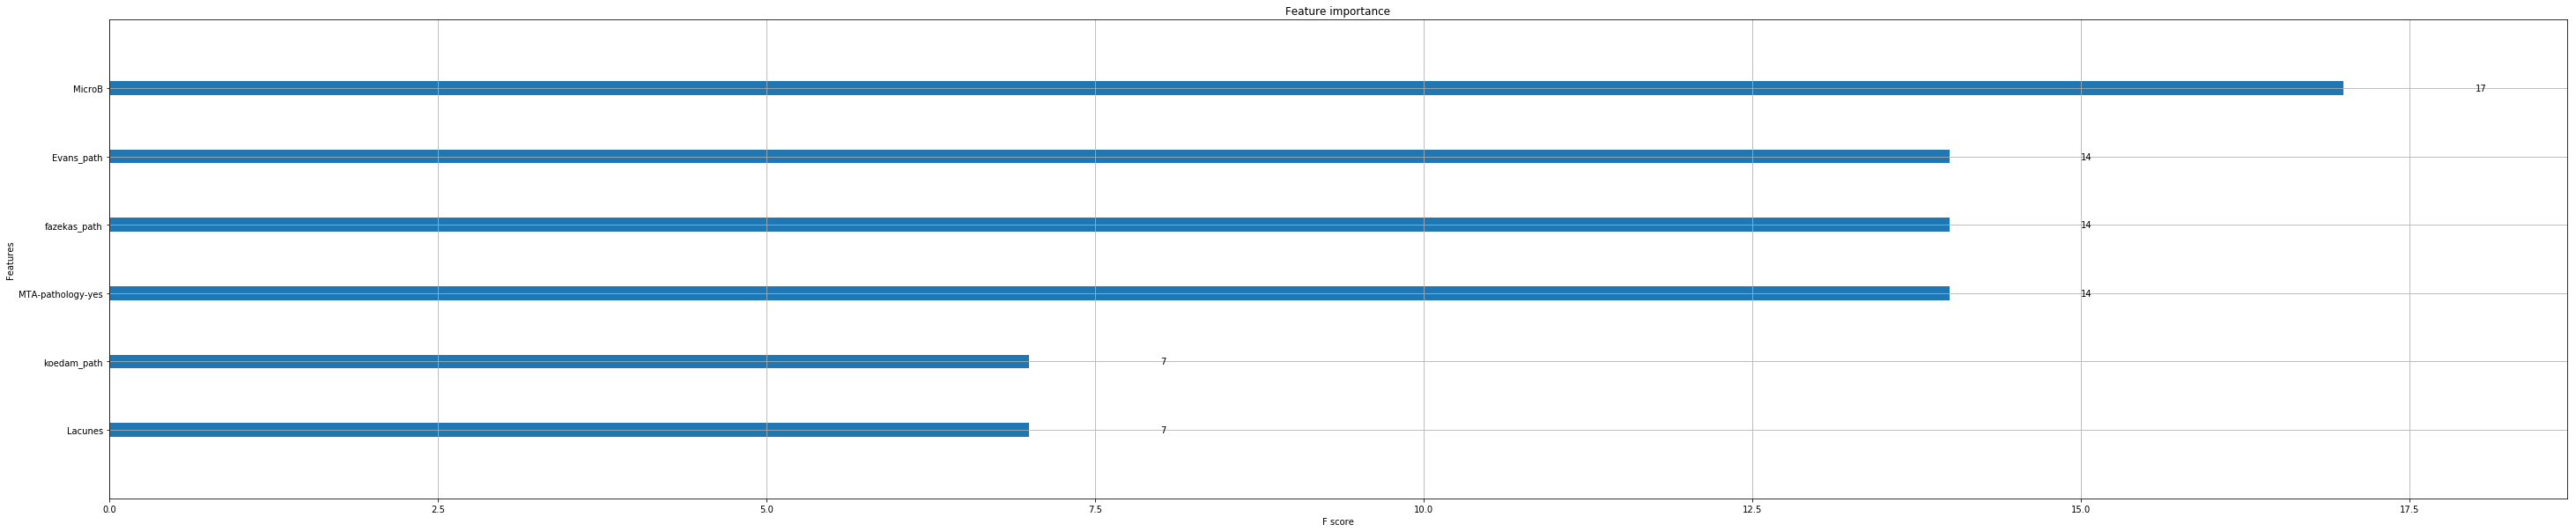

In [154]:
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

In [158]:
params = {'objective':'binary:logistic', 'colsample_bytree':0.8, 'learning_rate':0.1, 'max_depth':4, 'alpha':10, 'n_estimators':100} 

In [159]:
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics="error", as_pandas=True, seed=123)

[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:06:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

In [160]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.306173,0.007905,0.306173,0.03162
